## Q-learning (3 points)

This notebook will guide you through implementation of vanilla Q-learning algorithm.

You need to implement QLearningAgent (follow instructions for each method) and use it on a number of tests below.

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 128048 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.20.13-1ubuntu1~20.04.6_amd64.deb ...
Unpacking xvfb (2:1.20.13-1ubuntu1~20.04.6) ...
Setting up xvfb (2:1.20.13-1ubuntu1~20.04.6) ...
Processing triggers for man-db (2.9.1-1) ...
Starting virtual X frame buffer: Xvfb.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
%matplotlib inline
from collections import defaultdict
import random
import math

In [4]:
class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0
        value = -float('inf')
        for action in possible_actions: 
          q_value = self.get_qvalue(state, action)
          if q_value > value:
            value = q_value
        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        q_value = (1 - learning_rate) * self.get_qvalue(state, action) + learning_rate * (reward + gamma * self.get_value(next_state))

        self.set_qvalue(state, action, q_value)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        qvalue = -float('inf')
        best_action = None
        for action in possible_actions:
          new_qvalue = self.get_qvalue(state, action)
          if qvalue < new_qvalue:
            qvalue = new_qvalue
            best_action = action

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        chosen_action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon
        if epsilon > random.uniform(0, 1):
          chosen_action = random.choice(possible_actions)
        else:
          chosen_action = self.get_best_action(state)

        return chosen_action

### Try it on taxi

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [5]:
import gym
env = gym.make("Taxi-v3")

n_actions = env.action_space.n

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [15]:
agent = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

In [16]:
a = agent.get_action(env.reset())
print(agent.get_best_action(env.reset()))

0


In [17]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        # train (update) agent for state s
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

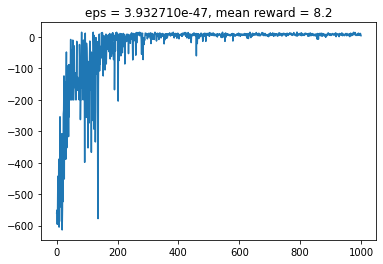

In [18]:
from IPython.display import clear_output

rewards = []
for i in range(1100):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.9

    if i % 100 == 0:
        clear_output(True)
        plt.title('eps = {:e}, mean reward = {:.1f}'.format(agent.epsilon, np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.show()

# Binarized state spaces

Use agent to train efficiently on `CartPole-v0`. This environment has a continuous set of possible states, so you will have to group them into bins somehow.

The simplest way is to use `round(x, n_digits)` (or `np.round`) to round a real number to a given amount of digits. The tricky part is to get the `n_digits` right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

In [11]:
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 58.2 MB/s eta 0:00:00


first state: [0.03415465 0.00213207 0.01626737 0.03433466]


/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


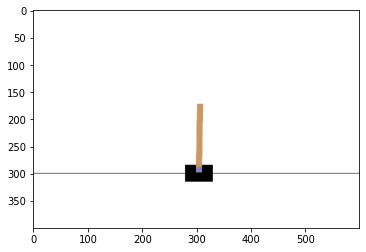

In [44]:
def make_env():
    return gym.make('CartPole-v0').env  # .env unwraps the TimeLimit wrapper

env = make_env()
n_actions = env.action_space.n

print("first state: %s" % (env.reset()))
plt.imshow(env.render('rgb_array'))

### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

In [45]:
def visualize_cartpole_observation_distribution(seen_observations):
    seen_observations = np.array(seen_observations)
    
    # The meaning of the observations is documented in
    # https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

    f, axarr = plt.subplots(2, 2, figsize=(16, 9), sharey=True)
    for i, title in enumerate(['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Velocity At Tip']):
        ax = axarr[i // 2, i % 2]
        ax.hist(seen_observations[:, i], bins=20)
        ax.set_title(title)
        xmin, xmax = ax.get_xlim()
        ax.set_xlim(min(xmin, -xmax), max(-xmin, xmax))
        ax.grid()
    f.tight_layout()

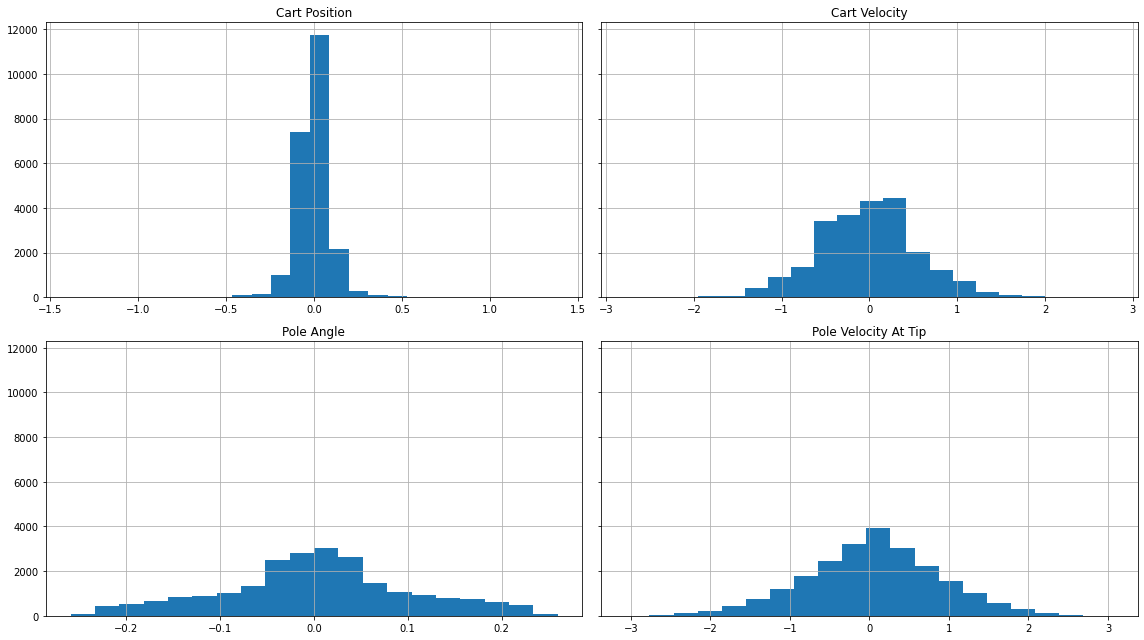

In [46]:
seen_observations = []
for _ in range(1000):
    seen_observations.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        seen_observations.append(s)

visualize_cartpole_observation_distribution(seen_observations)

## Binarize environment

In [66]:
from gym.core import ObservationWrapper
class Binarizer(ObservationWrapper):
    def __init__(self, env, digits = [0, 0, 0, 0]):
      super().__init__(env)
      self.digits = digits
    def observation(self, state):
        # Hint: you can do that with round(x, n_digits).
        # You may pick a different n_digits for each dimension.
        state[0] = np.round(state[0], self.digits[0])
        state[1] = np.round(state[1], self.digits[1])
        state[2] = np.round(state[2], self.digits[2])
        state[3] = np.round(state[3], self.digits[3])
        return tuple(state)

In [70]:
env = Binarizer(gym.make("CartPole-v0"), digits = [0, 0, 0, 0])

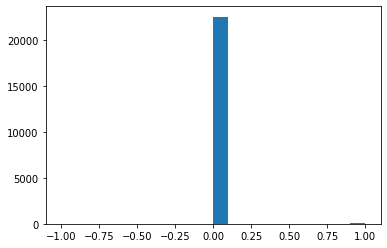

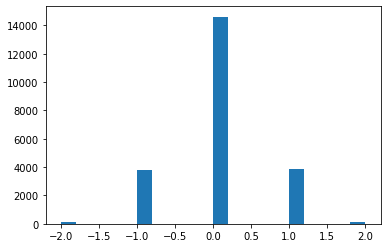

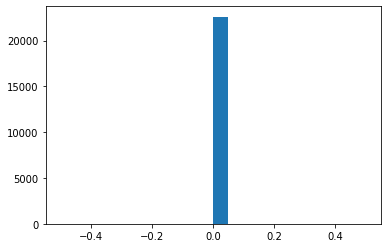

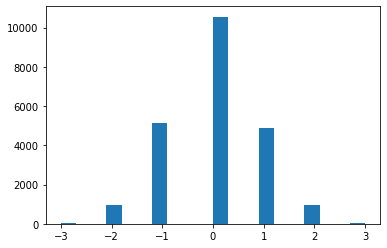

In [71]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:
            break

all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):

    plt.hist(all_states[:, obs_i], bins=20)
    plt.show()

## Learn binarized policy

Now let's train a policy that uses binarized state space.

__Tips:__ 
* If your binarization is too coarse, your agent may fail to find optimal policy. In that case, change binarization. 
* If your binarization is too fine-grained, your agent will take much longer than 1000 steps to converge. You can either increase number of iterations and decrease epsilon decay or change binarization.
* Having 10^3 ~ 10^4 distinct states is recommended (`len(QLearningAgent._qvalues)`), but not required.
* A reasonable agent should get to an average reward of >=50.

In [50]:
agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions=lambda s: range(n_actions))

In [78]:
digits_list = [[0, 0, 0, 0], [0, 1, 1, 1], [1, 1, 0, 1], [1, 1, 1, 1], [2, 2, 2, 2]]
for j in range(5):
  env = Binarizer(gym.make("CartPole-v0"), digits = digits_list[j])
  rewards = []
  start_time = time()
  for i in range(10000):
      rewards.append(play_and_train(env, agent))
      agent.epsilon *= 0.99
      # OPTIONAL YOUR CODE: adjust epsilon
  end_time = time()
  print(f'Средняя награда {np.mean(rewards)} для такого округления {env.digits}')
  print(f'Время выполнения: {end_time - start_time}')

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Средняя награда 15.013 для такого округления [0, 0, 0, 0]
Время выполнения: 10.403695583343506
Средняя награда 19.0466 для такого округления [0, 1, 1, 1]
Время выполнения: 17.43293333053589
Средняя награда 18.1035 для такого округления [1, 1, 0, 1]
Время выполнения: 18.25814175605774
Средняя награда 17.8921 для такого округления [1, 1, 1, 1]
Время выполнения: 16.4879412651062
Средняя награда 9.3367 для такого округления [2, 2, 2, 2]
Время выполнения: 7.894533634185791
